[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp451/blob/master/maximumLikelihood.ipynb)

# Maximum Likelihood
In this notebook we implement maximum likelihood estimate (MLE) for distributions that we saw in the [previous notebook](./probabilityTheory.ipynb). 
We will reuse `class`es from the previous notebook and add an `estimate` function that learns the parameters of those models (distributions) using MLE.

In [13]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt 
from IPython.core.debugger import set_trace #this is used for debugging
np.random.seed(1234) # whenver working with random numbers we can set the random seed to get the same output everytime

## 1. Bernoulli distribution
Lets assume that a thumbtack has a probability $0 < \mu^* < 1$ of _heads_ .
We use a **Bernoulli** distribution $\mathrm{Bernoulli}(x ; \mu) = \mu^{x} (1-\mu)^{1-x}$ to model this

In [14]:
# repeated from probabilityTheory.ipynb
class Bernoulli:
    '''
    class for Bernoulli distribution
    '''
    def __init__(self, mu=.5):
        self.mu = mu

    def density(self, x):
        # assuming x is a scalar or a numpy array of zeros and ones. The probabilities will have the same shape.
        p = self.mu * x + (1-self.mu) *(1-x)
        return p

    def sample(self, n):
        # returns a vector of length n
        u = np.random.rand(n)
        x = (u < self.mu).astype(float)
        return x

mu_star = .4
N = 10 # size of the dataset
thumbtack = Bernoulli(mu_star)
data = thumbtack.sample(N)
print(f'dataset: {data}')

dataset: [1. 0. 0. 0. 0. 1. 1. 0. 0. 0.]


The **likelihood** function for this dataset is
$$L(\mathcal{D},\mu) = \prod_{x \in \mathcal{D}} \mathrm{Bernoulli}(x; \mu)$$
Note that this is a function of $\mu$, it is not a probability distribution, so it doesn't sum to 1.
Next we plot this function, by calculating the product of the Bernoulli PMF for all datapoints in the `data`. 
We make this a function of $\mu$

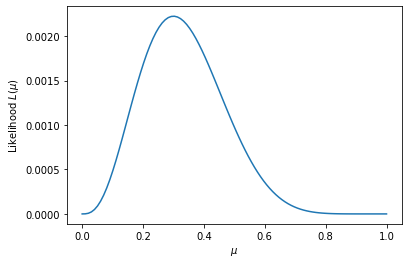

In [15]:
L = lambda mu: np.prod(Bernoulli(mu).density(data)) #likelihood is a function of mu
#let's plot this function
mu_vals = np.linspace(0,1,100)
L_vals = [L(mu) for mu in mu_vals]  
plt.plot(mu_vals, L_vals)
plt.xlabel(r"$\mu$")
plt.ylabel(r"Likelihood $L(\mu)$")
plt.show()

We can now add an `estimate` method to the `Bernoulli` class that use MLE.

In [16]:
def estimate(self, x):
    self.mu = x.mean() #max-likelihood estimate of mu
    return self.mu

Bernoulli.estimate = estimate

print(f'ground truth {thumbtack.mu}\nMLE estimate using 100 data-points {Bernoulli().estimate(thumbtack.sample(100))}')


ground truth 0.4
MLE estimate using 100 data-points 0.33


### 1.2 Increasing the size of dataset
**maximum likelihood** method for learning a probabilistic model picks $\theta$ that maximizes $L(\theta)$ for a given set of observations $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$. 
For _Bernoulli_ dist. max. likelihood estimate is the $\widehat{\theta} = \frac{1}{N} \sum_n x^{(n)}$, corresponding to the peak of the likelihood plot. The value of the likelihood shrinks exponentially as we increase the number of observations $N$ -- try `N=100` in the example above. 
A more numerically stable value with the same _maximum_ is the **log-likelihood** $LL(\mu) = \log(L(\mu))$. It is also customary to minimize the _negative log-likelihood_ (NLL).
Let's plot NLL for different $N$ -- as we increase our data-points the ML estimate often gets better. MLE is consistent, meaning that at the limit of infinite amount of data the estimate converges to the ground truth.

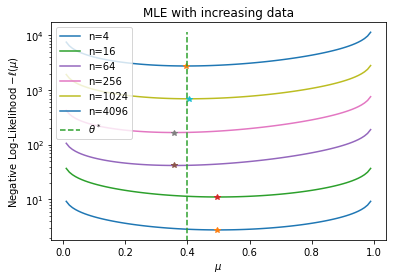

In [17]:

NLL = lambda mu, dataset: -np.sum(np.log(Bernoulli(mu).density(dataset))) #negative log likelihood for 
for r in range(1,7):
    N = 4**r   #size of the dataset for r-th iteration
    dataset = thumbtack.sample(N) 
    mu_vals = np.linspace(.01,.99,100)
    nll_vals = np.array([NLL(mu, dataset) for mu in mu_vals]) # log-likelihood for different mu in (0,1) range 
    plt.plot(mu_vals, nll_vals, label="n="+str(N))   #plot the log likelihood values
    max_ind = np.argmin(nll_vals)  # find index of the mu that minimizes the NLL 
    plt.plot(mu_vals[max_ind], nll_vals[max_ind], '*')

plt.plot([mu_star,mu_star], [0,nll_vals.max()], '--', label=r"$\theta^*$") #to get the vertical line for mu^*
plt.xlabel(r"$\mu$")
plt.ylabel(r"Negative Log-Likelihood $-\ell(\mu)$")
plt.yscale("log")
plt.title("MLE with increasing data")
plt.legend()
plt.show()

## 2. Multivariate Gaussian
For Gaussian the MLE of mean and covariance are given by the sample mean and covariance matrices.
Below we implement this addition to the `Gaussian` class.

In [18]:
class Gaussian():
    '''
    class for multivariate gaussian distribution
    '''
    def __init__(self, mu=0, sigma=0):
        self.mu = np.atleast_1d(mu)              #turns a scalar into 1D array otherwise preserves the arrray
        if np.array(sigma).ndim == 0:            #when sigma is scalar
            self.Sigma = np.atleast_2d(sigma**2) #turns a scalar into 2D array otherwise preserves the arrray
        else:
            self.Sigma = sigma

    def density(self, x):
        N,D = x.shape
        xm = (x-self.mu)                                                    
        normalization = ((2*np.pi)**(-D/2.)) * np.linalg.det(self.Sigma)**(-1/2.)
        quadratic = np.sum(xm @ np.linalg.inv(self.Sigma) * xm, -1)          #Note the @ sign here denotes matrix multiplication
        return normalization * np.exp(-.5 *  quadratic)
    
    def sample(self, N):
        L = np.linalg.cholesky(self.Sigma)
        D = self.mu.shape[0]
        x_std = np.random.randn(N,D)
        x = x_std @ L + self.mu
        return x
    
    def estimate(self, x):
        N, D = x.shape
        self.mu = np.mean(x, axis=0)
        xm = x-self.mu
        self.Sigma = (xm.T @ xm)/N #get the sigma by computing the covariance matrix

